### Library Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from scipy.stats import pearsonr, ttest_ind
from nltk.tokenize import TweetTokenizer
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack, csr_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
import scipy.sparse as sparse
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
import gensim
from gensim import corpora
from sklearn.linear_model import LinearRegression
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

**Figure Setup**

In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

# choose resolution of figures
plt.rcParams['figure.dpi'] = 300

font = {'family' : 'serif'}
plt.rc('font', **font)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## **Part I: Sentiment Analysis with a Twitter Dataset**

In [ ]:
#Importing the dataset

train_data = pd.read_csv('https://raw.githubusercontent.com/TJ838/JSC270HW4/main/covid-tweets-train.csv', header=None)
test_data = pd.read_csv('https://raw.githubusercontent.com/TJ838/JSC270HW4/main/covid-tweets-test.csv', header=None)

train_data.columns = ['Index','OriginalTweet', 'Sentiment']
test_data.columns = ['Index','OriginalTweet', 'Sentiment']
train_data = train_data[train_data['Sentiment'].isin(['0','1','2'])]
test_data = test_data[test_data['Sentiment'].isin(['0','1','2'])]

train_data.head(10)

,Index,OriginalTweet,Sentiment
1,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
2,1.0,advice Talk to your neighbours family to excha...,2
3,2.0,Coronavirus Australia: Woolworths to give elde...,2
4,3.0,My food stock is not the only one which is emp...,2
5,4.0,"Me, ready to go at supermarket during the #COV...",0
6,5.0,As news of the regionÂs first confirmed COVID...,2
7,6.0,Cashier at grocery store was sharing his insig...,2
8,7.0,Was at the supermarket today. Didn't buy toile...,1
9,8.0,Due to COVID-19 our retail store and classroom...,2
10,9.0,"For corona prevention,we should stop to buy th...",0


In [ ]:
# A
class_counts = train_data['Sentiment'].value_counts()
total_observations = len(train_data)

for sentiment, count in class_counts.items():
    proportion = count / total_observations * 100
    print(f"Sentiment {sentiment} count: {count}")
    print(f"Sentiment {sentiment} proportion: {proportion:.2f}%")

Sentiment 2 count: 18042
Sentiment 2 proportion: 43.84%
Sentiment 0 count: 15397
Sentiment 0 proportion: 37.42%
Sentiment 1 count: 7712
Sentiment 1 proportion: 18.74%


In [ ]:
# B

# Create a tokenizer object
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

# Tokenize the tweets
train_data['Token'] = train_data['OriginalTweet'].apply(tokenizer.tokenize)
test_data['Token'] = test_data['OriginalTweet'].apply(tokenizer.tokenize)

train_data.head()

,Index,OriginalTweet,Sentiment,Token
1,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[https://t.co/iFz9FAn2Pa, and, https://t.co/xX..."
2,1.0,advice Talk to your neighbours family to excha...,2,"[advice, talk, to, your, neighbours, family, t..."
3,2.0,Coronavirus Australia: Woolworths to give elde...,2,"[coronavirus, australia, :, woolworths, to, gi..."
4,3.0,My food stock is not the only one which is emp...,2,"[my, food, stock, is, not, the, only, one, whi..."
5,4.0,"Me, ready to go at supermarket during the #COV...",0,"[me, ,, ready, to, go, at, supermarket, during..."


In [ ]:
# C

train_data['Token'] = train_data['Token'].apply(lambda x: [token for token in x if not re.match(r'^http', token)])
test_data['Token'] = test_data['Token'].apply(lambda x: [token for token in x if not re.match(r'^http', token)])


train_data.head()

,Index,OriginalTweet,Sentiment,Token
1,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[and, and]"
2,1.0,advice Talk to your neighbours family to excha...,2,"[advice, talk, to, your, neighbours, family, t..."
3,2.0,Coronavirus Australia: Woolworths to give elde...,2,"[coronavirus, australia, :, woolworths, to, gi..."
4,3.0,My food stock is not the only one which is emp...,2,"[my, food, stock, is, not, the, only, one, whi..."
5,4.0,"Me, ready to go at supermarket during the #COV...",0,"[me, ,, ready, to, go, at, supermarket, during..."


In [ ]:
# D
train_data['Token'] = train_data['Token'].apply(lambda x: [re.sub(r'[,.?!;:’"“”@#$+=&]', '', token) for token in x])
train_data['Token'] = train_data['Token'].apply(lambda x: [token.lower() for token in x])
test_data['Token'] = test_data['Token'].apply(lambda x: [re.sub(r'[,.?!;:’"“”@#$+=&]', '', token) for token in x])
test_data['Token'] = test_data['Token'].apply(lambda x: [token.lower() for token in x])
train_data.head()

,Index,OriginalTweet,Sentiment,Token
1,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[and, and]"
2,1.0,advice Talk to your neighbours family to excha...,2,"[advice, talk, to, your, neighbours, family, t..."
3,2.0,Coronavirus Australia: Woolworths to give elde...,2,"[coronavirus, australia, , woolworths, to, giv..."
4,3.0,My food stock is not the only one which is emp...,2,"[my, food, stock, is, not, the, only, one, whi..."
5,4.0,"Me, ready to go at supermarket during the #COV...",0,"[me, , ready, to, go, at, supermarket, during,..."


In [ ]:
# E

stemmer = PorterStemmer()
train_data['Token'] = train_data['Token'].apply(lambda x: [stemmer.stem(token) for token in x])
test_data['Token'] = test_data['Token'].apply(lambda x: [stemmer.stem(token) for token in x])
train_data.head()

,Index,OriginalTweet,Sentiment,Token
1,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[and, and]"
2,1.0,advice Talk to your neighbours family to excha...,2,"[advic, talk, to, your, neighbour, famili, to,..."
3,2.0,Coronavirus Australia: Woolworths to give elde...,2,"[coronaviru, australia, , woolworth, to, give,..."
4,3.0,My food stock is not the only one which is emp...,2,"[my, food, stock, is, not, the, onli, one, whi..."
5,4.0,"Me, ready to go at supermarket during the #COV...",0,"[me, , readi, to, go, at, supermarket, dure, t..."


In [ ]:
# F
nltk.download('stopwords')
stop_words = stopwords.words('english')[:100]
train_data['Token'] = train_data['Token'].apply(lambda x: [token for token in x if token not in stop_words])
test_data['Token'] = test_data['Token'].apply(lambda x: [token for token in x if token not in stop_words])
train_data['Token'] = train_data['Token'].apply(lambda x: [token for token in x if token != ''])
test_data['Token'] = test_data['Token'].apply(lambda x: [token for token in x if token != ''])

train_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Index,OriginalTweet,Sentiment,Token
1,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,[]
2,1.0,advice Talk to your neighbours family to excha...,2,"[advic, talk, neighbour, famili, exchang, phon..."
3,2.0,Coronavirus Australia: Woolworths to give elde...,2,"[coronaviru, australia, woolworth, give, elder..."
4,3.0,My food stock is not the only one which is emp...,2,"[food, stock, not, onli, one, empti, pleas, do..."
5,4.0,"Me, ready to go at supermarket during the #COV...",0,"[readi, go, supermarket, dure, covid19, outbre..."


In [ ]:
# G

train_data["Token_string"] = train_data["Token"].apply(lambda x: " ".join(x))

vectorizer = CountVectorizer()

# Fit the vectorizer on the text data
vectorizer.fit(train_data["Token_string"])

# Transform the text data into a matrix of token counts
matrix_of_token_counts = vectorizer.transform(train_data["Token_string"])

print(matrix_of_token_counts.toarray())

# Print the vocabulary of the vectorizer
print(vectorizer.vocabulary_)

matrix_dimensions = matrix_of_token_counts.shape
print(f"Matrix dimensions: {matrix_dimensions}")


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
{'advic': 2561, 'talk': 32961, 'neighbour': 23301, 'famili': 12975, 'exchang': 12696, 'phone': 25852, 'number': 24033, 'creat': 9452, 'contact': 8359, 'list': 20247, 'school': 29567, 'employ': 12182, 'chemist': 7261, 'gp': 15263, 'set': 30000, 'onlin': 24502, 'shop': 30318, 'account': 2372, 'poss': 26385, 'adequ': 2489, 'suppli': 32584, 'regular': 27976, 'med': 21613, 'not': 23864, 'order': 24658, 'coronaviru': 8701, 'australia': 4041, 'woolworth': 37168, 'give': 14880, 'elderli': 12014, 'disabl': 10858, 'dedic': 10285, 'hour': 16821, 'amid': 3177, 'covid': 9088, '19': 565, 'outbreak': 24784, 'food': 13769, 'stock': 32024, 'onli': 24501, 'one': 24464, 'empti': 12195, 'pleas': 26096, 'don': 11194, 'panic': 25168, 'there': 33566, 'will': 36941, 'enough': 12295, 'everyon': 12632, 'take': 32924, 'more': 22470, 'than': 33387, 'need': 23268, 'stay': 31745, 'calm': 6422, 'sa

In [ ]:
test_data["Token_string"] = test_data["Token"].apply(lambda x: " ".join(x))

vectorizer2 = CountVectorizer()

vectorizer2.fit(test_data["Token_string"])

matrix_of_token_counts2 = vectorizer2.transform(test_data["Token_string"])

print(matrix_of_token_counts2.toarray())

print(vectorizer2.vocabulary_)

matrix_dimensions = matrix_of_token_counts2.shape
print(f"Matrix dimensions: {matrix_dimensions}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
{'trend': 7815, 'new': 5221, 'yorker': 8555, 'encount': 2771, 'empti': 2762, 'supermarket': 7382, 'shelv': 6816, 'pictur': 5808, 'wegman': 8301, 'brooklyn': 1252, 'sold': 7043, 'out': 5519, 'onlin': 5447, 'grocer': 3539, 'foodkick': 3189, 'maxdeliveri': 4825, 'coronavirus': 1941, 'fear': 3041, 'shopper': 6854, 'stock': 7243, 'when': 8347, 'couldn': 2025, 'find': 3096, 'hand': 3624, 'sanit': 6616, 'fred': 3266, 'meyer': 4911, 'turn': 7887, 'amazon': 608, '11497': 44, 'pack': 5573, 'purel': 6128, 'check': 1554, 'how': 3858, 'coronaviru': 1940, 'concern': 1786, 'drive': 2596, 'price': 6011, 'can': 1377, 'protect': 6080, 'love': 4665, 'one': 5442, 'panic': 5617, 'buy': 1326, 'hit': 3771, 'newyork': 5232, 'citi': 1622, 'anxiou': 680, 'food': 3177, 'medic': 4857, 'suppli': 7394, 'healthcar': 3685, 'worker': 8453, '30': 186, 'becom': 981, 'bigappl': 1066, '1st': 111, 'confir

In [ ]:
# H

# Combine the training and test data
combined_data = pd.concat([train_data["Token_string"], test_data["Token_string"]])

# Fit a new CountVectorizer on the combined data
vectorizer_combined = CountVectorizer()
vectorizer_combined.fit(combined_data)

# Transform both training and test data using the combined vectorizer such that their vocabulary match
X_train = vectorizer_combined.transform(train_data["Token_string"])
X_test = vectorizer_combined.transform(test_data["Token_string"])


# Create a Multinomial Naive Bayes model
model = MultinomialNB(alpha=1.0)

# Train the model
model.fit(X_train, train_data["Sentiment"])

# Evaluate the model
predicted_labels = model.predict(X_test)
train_accuracy = accuracy_score(train_data["Sentiment"], model.predict(X_train))
test_accuracy = accuracy_score(test_data["Sentiment"], predicted_labels)

# Print the results
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

print(X_train.shape)
print(X_test.shape)

Training accuracy: 0.7850
Test accuracy: 0.6796
(41151, 39744)
(3798, 39744)


In [ ]:
# Find the top 5 most probable words for each class
class_names = train_data["Sentiment"].unique()
for class_name in class_names:
    top_words = np.argsort(model.feature_log_prob_[class_names == class_name].sum(axis=0))[-5:]
    top_words_2d = top_words.reshape(1, -1)
    top_words_counts = X_train[train_data["Sentiment"] == class_name].toarray()[:, top_words].sum(axis=0)
    print(f"\nTop 5 words for class {class_name}:")
    for word_index, count in zip(top_words, top_words_counts):
        word = vectorizer_combined.get_feature_names_out()[word_index]
        print(f"\t- {word}: {count}")


Top 5 words for class 1:
	- food: 712
	- price: 1370
	- covid: 2177
	- 19: 2198
	- coronaviru: 3817

Top 5 words for class 2:
	- supermarket: 3319
	- store: 3931
	- covid: 5361
	- 19: 5558
	- coronaviru: 7521

Top 5 words for class 0:
	- thi: 3230
	- store: 2697
	- covid: 4758
	- 19: 4925
	- coronaviru: 6745


In [ ]:
# J

# Vectorize the data using TF-IDF
vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(combined_data)
X_train_tfidf = vectorizer_tfidf.transform(train_data["Token_string"])
X_test_tfidf = vectorizer_tfidf.transform(test_data["Token_string"])


# Fit the Naive Bayes model
clf = MultinomialNB()
clf.fit(X_train_tfidf, train_data["Sentiment"])

# Predict the labels
y_pred_train = clf.predict(X_train_tfidf)
y_pred_test = clf.predict(X_test_tfidf)

# Calculate the training and test accuracy
train_accuracy1 = accuracy_score(train_data["Sentiment"], y_pred_train)
test_accuracy1 = accuracy_score(test_data["Sentiment"], y_pred_test)

# Print the results

print(f"Training accuracy with TF-IDF: {train_accuracy1:.4f}")
print(f"Test accuracy with TF-IDF: {test_accuracy1:.4f}")

# Compare with the accuracy using count vectors
print(f"Training accuracy with count vectors: {train_accuracy:.4f}")
print(f"Test accuracy with count vectors: {test_accuracy:.4f}")

Training accuracy with TF-IDF: 0.7159
Test accuracy with TF-IDF: 0.6419
Training accuracy with count vectors: 0.7850
Test accuracy with count vectors: 0.6796


In [ ]:
# K

train_data1 = pd.read_csv('https://raw.githubusercontent.com/TJ838/JSC270HW4/main/covid-tweets-train.csv', header=None)
test_data1 = pd.read_csv('https://raw.githubusercontent.com/TJ838/JSC270HW4/main/covid-tweets-test.csv', header=None)

train_data1.columns = ['Index','OriginalTweet', 'Sentiment']
test_data1.columns = ['Index','OriginalTweet', 'Sentiment']
train_data1 = train_data1[train_data1['Sentiment'].isin(['0','1','2'])]
test_data1 = test_data1[test_data1['Sentiment'].isin(['0','1','2'])]

In [ ]:
# Create a tokenizer object
tokenizer1 = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

# Tokenize the tweets
train_data1['Token'] = train_data1['OriginalTweet'].apply(tokenizer1.tokenize)

# Tokenize the tweets
test_data1['Token'] = test_data1['OriginalTweet'].apply(tokenizer1.tokenize)

train_data1['Token'] = train_data1['Token'].apply(lambda x: [token for token in x if not re.match(r'^http', token)])
test_data1['Token'] = test_data1['Token'].apply(lambda x: [token for token in x if not re.match(r'^http', token)])

train_data1['Token'] = train_data1['Token'].apply(lambda x: [re.sub(r'[,.?!;:’"“”@#$+=&]', '', token) for token in x])
train_data1['Token'] = train_data1['Token'].apply(lambda x: [token.lower() for token in x])
test_data1['Token'] = test_data1['Token'].apply(lambda x: [re.sub(r'[,.?!;:’"“”@#$+=&]', '', token) for token in x])
test_data1['Token'] = test_data1['Token'].apply(lambda x: [token.lower() for token in x])

train_data1.head()

,Index,OriginalTweet,Sentiment,Token
1,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[and, and]"
2,1.0,advice Talk to your neighbours family to excha...,2,"[advice, talk, to, your, neighbours, family, t..."
3,2.0,Coronavirus Australia: Woolworths to give elde...,2,"[coronavirus, australia, , woolworths, to, giv..."
4,3.0,My food stock is not the only one which is emp...,2,"[my, food, stock, is, not, the, only, one, whi..."
5,4.0,"Me, ready to go at supermarket during the #COV...",0,"[me, , ready, to, go, at, supermarket, during,..."


In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
train_data1['Token'] = train_data1['Token'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
test_data1['Token'] = test_data1['Token'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
train_data1.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Index,OriginalTweet,Sentiment,Token
1,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[and, and]"
2,1.0,advice Talk to your neighbours family to excha...,2,"[advice, talk, to, your, neighbour, family, to..."
3,2.0,Coronavirus Australia: Woolworths to give elde...,2,"[coronavirus, australia, , woolworth, to, give..."
4,3.0,My food stock is not the only one which is emp...,2,"[my, food, stock, is, not, the, only, one, whi..."
5,4.0,"Me, ready to go at supermarket during the #COV...",0,"[me, , ready, to, go, at, supermarket, during,..."


In [ ]:
train_data1['Token'] = train_data1['Token'].apply(lambda x: [token for token in x if token not in stop_words])
test_data1['Token'] = test_data1['Token'].apply(lambda x: [token for token in x if token not in stop_words])
train_data1['Token'] = train_data1['Token'].apply(lambda x: [token for token in x if token != ''])
test_data1['Token'] = test_data1['Token'].apply(lambda x: [token for token in x if token != ''])

train_data1.head()

,Index,OriginalTweet,Sentiment,Token
1,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,[]
2,1.0,advice Talk to your neighbours family to excha...,2,"[advice, talk, neighbour, family, exchange, ph..."
3,2.0,Coronavirus Australia: Woolworths to give elde...,2,"[coronavirus, australia, woolworth, give, elde..."
4,3.0,My food stock is not the only one which is emp...,2,"[food, stock, not, only, one, empty, please, d..."
5,4.0,"Me, ready to go at supermarket during the #COV...",0,"[ready, go, supermarket, covid19, outbreak, no..."


In [ ]:
train_data1["Token_string"] = train_data1["Token"].apply(lambda x: " ".join(x))
test_data1["Token_string"] = test_data1["Token"].apply(lambda x: " ".join(x))


combined_data1 = pd.concat([train_data1["Token_string"], test_data1["Token_string"]])

# Vectorize the data using TF-IDF
vectorizer_tfidf1 = TfidfVectorizer()
vectorizer_tfidf1.fit(combined_data1)
X_train_tfidf1 = vectorizer_tfidf1.transform(train_data1["Token_string"])
X_test_tfidf1 = vectorizer_tfidf1.transform(test_data1["Token_string"])


# Fit the Naive Bayes model
clf1 = MultinomialNB()
clf1.fit(X_train_tfidf1, train_data1["Sentiment"])

# Predict the labels
y_pred_train1 = clf1.predict(X_train_tfidf1)
y_pred_test1 = clf1.predict(X_test_tfidf1)

# Calculate the training and test accuracy
train_accuracy2 = accuracy_score(train_data1["Sentiment"], y_pred_train1)
test_accuracy2 = accuracy_score(test_data1["Sentiment"], y_pred_test1)

# Print the results

print(f"Training accuracy with lemmatization: {train_accuracy2:.4f}")
print(f"Test accuracy with lemmatization: {test_accuracy2:.4f}")

# Compare with the accuracy using stemmers
print(f"Training accuracy with stemmers: {train_accuracy1:.4f}")
print(f"Test accuracy with stemmers: {test_accuracy1:.4f}")

Training accuracy with lemmatization: 0.7252
Test accuracy with lemmatization: 0.6445
Training accuracy with stemmers: 0.7159
Test accuracy with stemmers: 0.6419


## **Part II: Hate Speech Detection**

[Part II Report Link](https://docs.google.com/document/d/1Kd7RJdiQTUPtSPcZTO6UwLonHlmCkhY7x5SotVjKofE/edit?usp=sharing)

### *Importing and Cleaning Data*

#### Importing Data ([Source](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset))

In [ ]:
tweets_df = pd.read_csv('https://raw.githubusercontent.com/TJ838/JSC270HW4/main/labeled_data.csv')

In [ ]:
# make sure we are only working with labeled data that exists, and convert to numeric
tweets_df = tweets_df[tweets_df['class'].isin([0,1,2])]
tweets_df = tweets_df.dropna(subset=['tweet'])
tweets_df.rename(columns={
    "Unnamed: 0": "index",
    "class": "sentiment",
    "tweet": "original_tweet"
}, inplace=True)
tweets_df.head()

,index,count,hate_speech,offensive_language,neither,sentiment,original_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


#### Preprocessing Tweets

In [ ]:
# tokenize the data
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
tweets_df['tokens'] = tweets_df['original_tweet'].apply(tokenizer.tokenize)

# remove https
tweets_df['tokens'] = tweets_df['tokens'].apply(lambda x: [token for token in x if not re.match(r'^http', token)])

# remove punctuation
tweets_df['tokens'] = tweets_df['tokens'].apply(lambda x: [re.sub(r'[-,.?!;:’"“”@#$+=&]', '', token) for token in x])

tweets_df.head()

,index,count,hate_speech,offensive_language,neither,sentiment,original_tweet,tokens
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[, , , rt, , as, a, woman, you, shouldn't, com..."
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[, , , rt, , boy, dats, cold, , tyga, dwn, bad..."
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[, , , rt, dawg, , , , rt, , you, ever, fuck, ..."
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[, , , rt, , she, look, like, a, tranny]"
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[, , , rt, , the, shit, you, hear, about, me, ..."


In [ ]:
# lemmatize
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
tweets_df['tokens'] = tweets_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

# remove null tokens and stopwords and RT
nltk.download('stopwords')
stop_words = stopwords.words('english')[:100]
tweets_df['tokens'] = tweets_df['tokens'].apply(lambda x: [token for token in x if token not in stop_words])
tweets_df['tokens'] = tweets_df['tokens'].apply(lambda x: [token for token in x if token != ''])
tweets_df['tokens'] = tweets_df['tokens'].apply(lambda x: [token for token in x if token != 'rt'])

tweets_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,index,count,hate_speech,offensive_language,neither,sentiment,original_tweet,tokens
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[woman, shouldn't, complain, cleaning, house, ..."
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ..."
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[dawg, ever, fuck, bitch, start, cry, confused..."
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[look, like, tranny]"
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[shit, hear, might, true, might, faker, than, ..."


#### Generating New Features

In [ ]:
# want to know how "confident" the assertion that a tweet is hate speech/offensive language/neither is
tweets_df['hate_proportion'] = tweets_df['hate_speech'] / tweets_df['count']
tweets_df['offensive_proportion'] = tweets_df['offensive_language'] / tweets_df['count']
tweets_df['neither_proportion'] = tweets_df['neither'] / tweets_df['count']
tweets_df.head()

,index,count,hate_speech,offensive_language,neither,sentiment,original_tweet,tokens,hate_proportion,offensive_proportion,neither_proportion
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[woman, shouldn't, complain, cleaning, house, ...",0.0,0.000000,1.000000
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...",0.0,1.000000,0.000000
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[dawg, ever, fuck, bitch, start, cry, confused...",0.0,1.000000,0.000000
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[look, like, tranny]",0.0,0.666667,0.333333
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[shit, hear, might, true, might, faker, than, ...",0.0,1.000000,0.000000


In [ ]:
# split the data into hate speech (0), offensive language (1), and neutral (2) tweets
df_sentiment_0 = tweets_df[tweets_df["sentiment"] == 0]
df_sentiment_1 = tweets_df[tweets_df["sentiment"] == 1]
df_sentiment_2 = tweets_df[tweets_df["sentiment"] == 2]


In [ ]:
df_sentiment_0.head() # some tweets flagged as hate speech

,index,count,hate_speech,offensive_language,neither,sentiment,original_tweet,tokens,hate_proportion,offensive_proportion,neither_proportion
85,85,3,2,1,0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...","[queer, gaywad]",0.666667,0.333333,0.0
89,90,3,3,0,0,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...","[alsarabsss, beaner, smh, can, tell, mexican]",1.000000,0.000000,0.0
110,111,3,3,0,0,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b...","[fucking, gay, blacklisted, hoe, holding, tehg...",1.000000,0.000000,0.0
184,186,3,3,0,0,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...","[lmfaooo, hate, black, people, why, there's, b...",1.000000,0.000000,0.0
202,204,3,2,1,0,0,"""@NoChillPaz: ""At least I'm not a nigger"" http...","[least, i'm, not, nigger, lmfao]",0.666667,0.333333,0.0


In [ ]:
df_sentiment_1.head() # some tweets flagged as offensive

,index,count,hate_speech,offensive_language,neither,sentiment,original_tweet,tokens,hate_proportion,offensive_proportion,neither_proportion
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...",0.000000,1.000000,0.000000
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[dawg, ever, fuck, bitch, start, cry, confused...",0.000000,1.000000,0.000000
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[look, like, tranny]",0.000000,0.666667,0.333333
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[shit, hear, might, true, might, faker, than, ...",0.000000,1.000000,0.000000
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...","[shit, just, blow, claim, so, faithful, somebo...",0.333333,0.666667,0.000000


In [ ]:
df_sentiment_2.head() # some tweets flagged as neutral

,index,count,hate_speech,offensive_language,neither,sentiment,original_tweet,tokens,hate_proportion,offensive_proportion,neither_proportion
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[woman, shouldn't, complain, cleaning, house, ...",0.0,0.000000,1.000000
40,40,3,0,1,2,2,""" momma said no pussy cats inside my doghouse ""","[momma, said, no, pussy, cat, inside, doghouse]",0.0,0.333333,0.666667
63,63,3,0,0,3,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://...","[simplyaddictedtoguys, woof, woof, hot, scally...",0.0,0.000000,1.000000
66,66,3,0,1,2,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo...","[woof, woof, hot, sol]",0.0,0.333333,0.666667
67,67,3,0,1,2,2,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these...","[lemmie, eat, oreo, dish, one, oreo, lol]",0.0,0.333333,0.666667


### *Exploratory Data Analysis*

#### Quick Summary Statistics

In [ ]:
tweets_df.describe()

,index,count,hate_speech,offensive_language,neither,sentiment,hate_proportion,offensive_proportion,neither_proportion
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277,0.087243,0.739886,0.172871
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089,0.196461,0.363079,0.341761
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.666667,0.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000,1.000000,1.000000,1.000000


In [ ]:
tweets_df.info()

sentiment_counts = tweets_df['sentiment'].value_counts()
size = len(tweets_df)
sentiment_map = {2: 'Neither', 0: 'Hate Speech', 1: 'Offensive Language'}

print("\nSentiments as a Proportion of All Tweets:")
for sentiment, count in sentiment_counts.items():
  proportion = 100 * count / size
  print(f"\t{sentiment_map[sentiment]}: {proportion:.2f}%")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 24783 non-null  int64  
 1   count                 24783 non-null  int64  
 2   hate_speech           24783 non-null  int64  
 3   offensive_language    24783 non-null  int64  
 4   neither               24783 non-null  int64  
 5   sentiment             24783 non-null  int64  
 6   original_tweet        24783 non-null  object 
 7   tokens                24783 non-null  object 
 8   hate_proportion       24783 non-null  float64
 9   offensive_proportion  24783 non-null  float64
 10  neither_proportion    24783 non-null  float64
dtypes: float64(3), int64(6), object(2)
memory usage: 2.1+ MB

Sentiments as a Proportion of All Tweets:
	Offensive Language: 77.43%
	Neither: 16.80%
	Hate Speech: 5.77%


#### Exploratory Visualizations

*How many of each tweet type are there?*

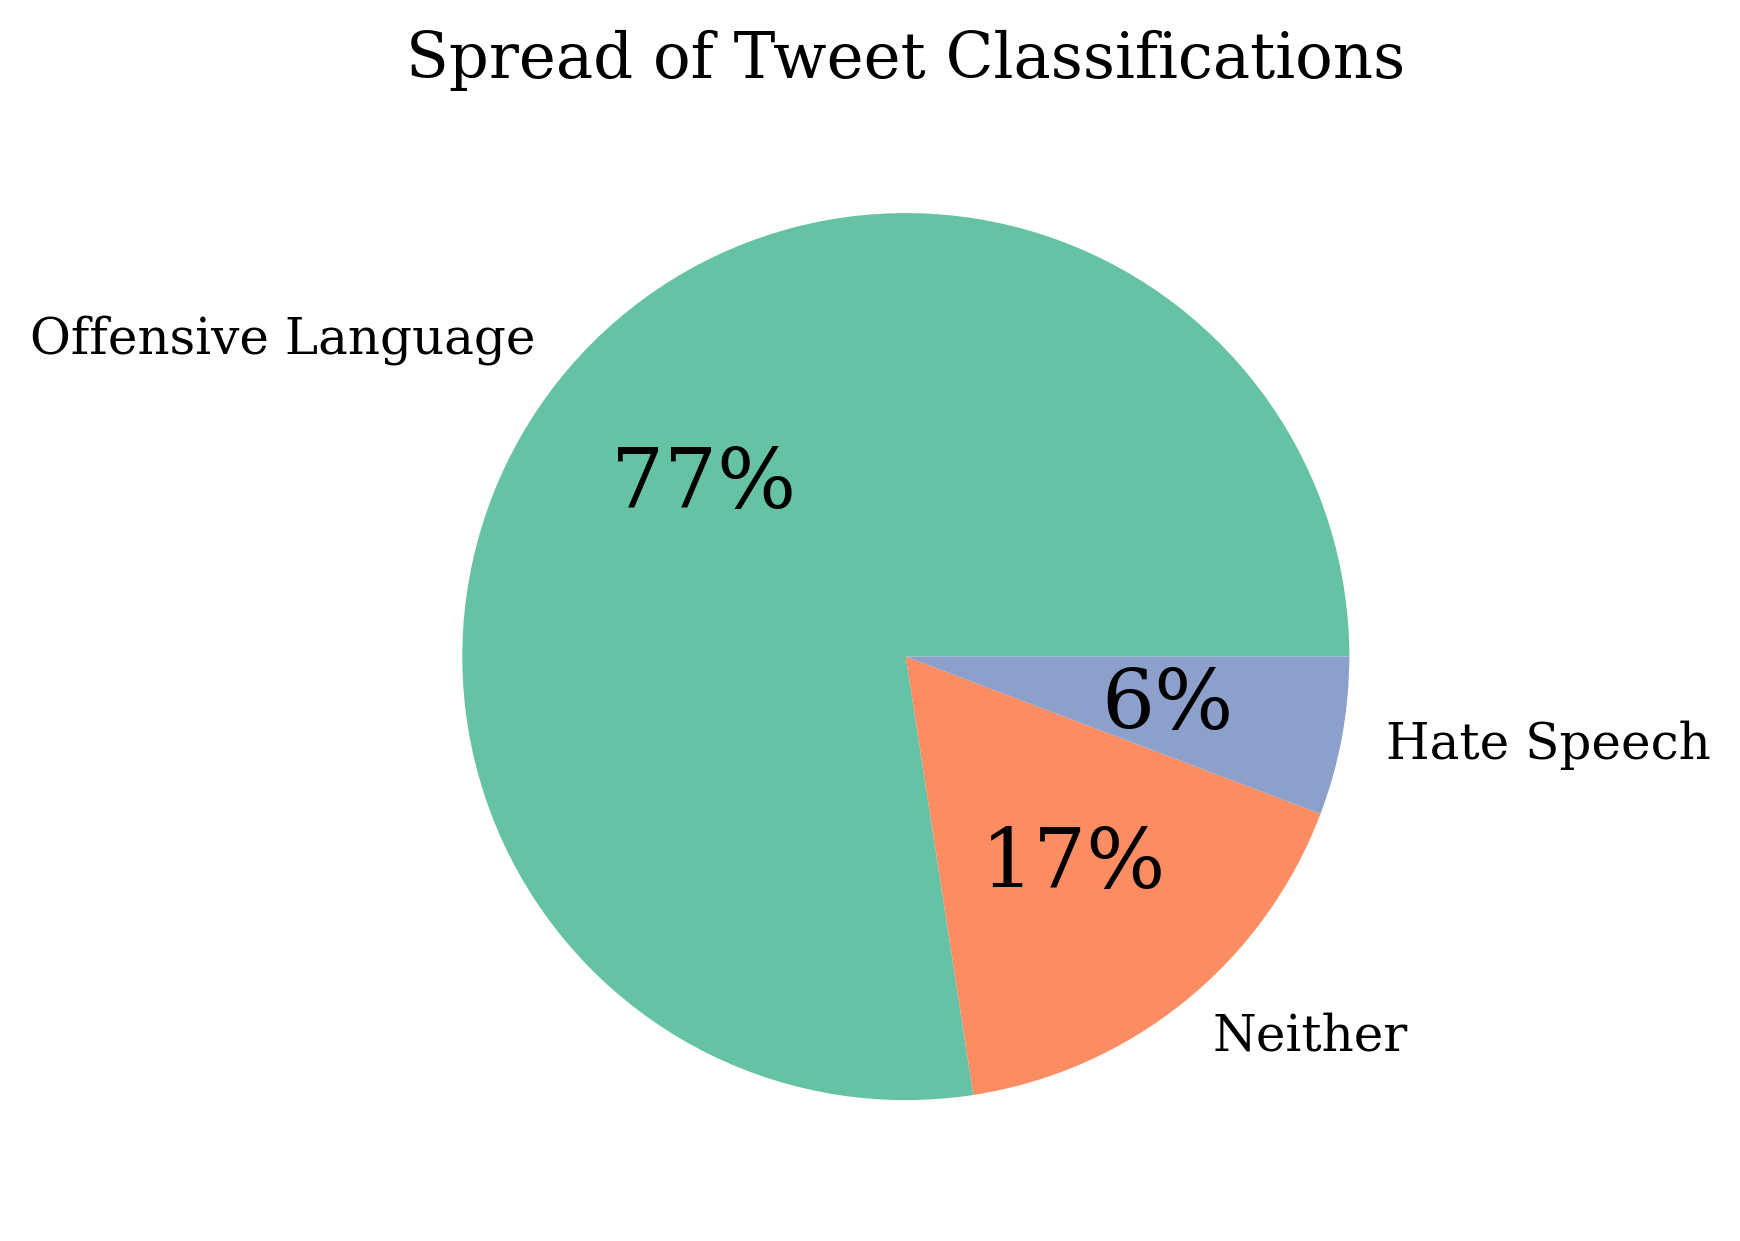

In [ ]:
patches, texts, autotexts = plt.pie(tweets_df['sentiment'].value_counts(), colors=sns.color_palette("Set2"), labels=['Offensive Language', 'Neither', 'Hate Speech'], autopct='%.0f%%', textprops={'fontsize': 20})
for label in texts:
  label.set_fontsize(12)
plt.title("Spread of Tweet Classifications")
plt.show()

*How sure are the labels (i.e. was it 100% consensus that it was hate speech, or maybe only 60%) of the tweets?*

In [ ]:
df_sentiment_0['hate_proportion'].describe()

count    1430.000000
mean        0.728008
std         0.130551
min         0.444444
25%         0.666667
50%         0.666667
75%         0.666667
max         1.000000
Name: hate_proportion, dtype: float64

In [ ]:
df_sentiment_1['offensive_proportion'].describe()

count    19190.000000
mean         0.919499
std          0.140950
min          0.444444
25%          0.833333
50%          1.000000
75%          1.000000
max          1.000000
Name: offensive_proportion, dtype: float64

In [ ]:
df_sentiment_2['neither_proportion'].describe()

count    4163.000000
mean        0.898687
std         0.152917
min         0.500000
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
Name: neither_proportion, dtype: float64

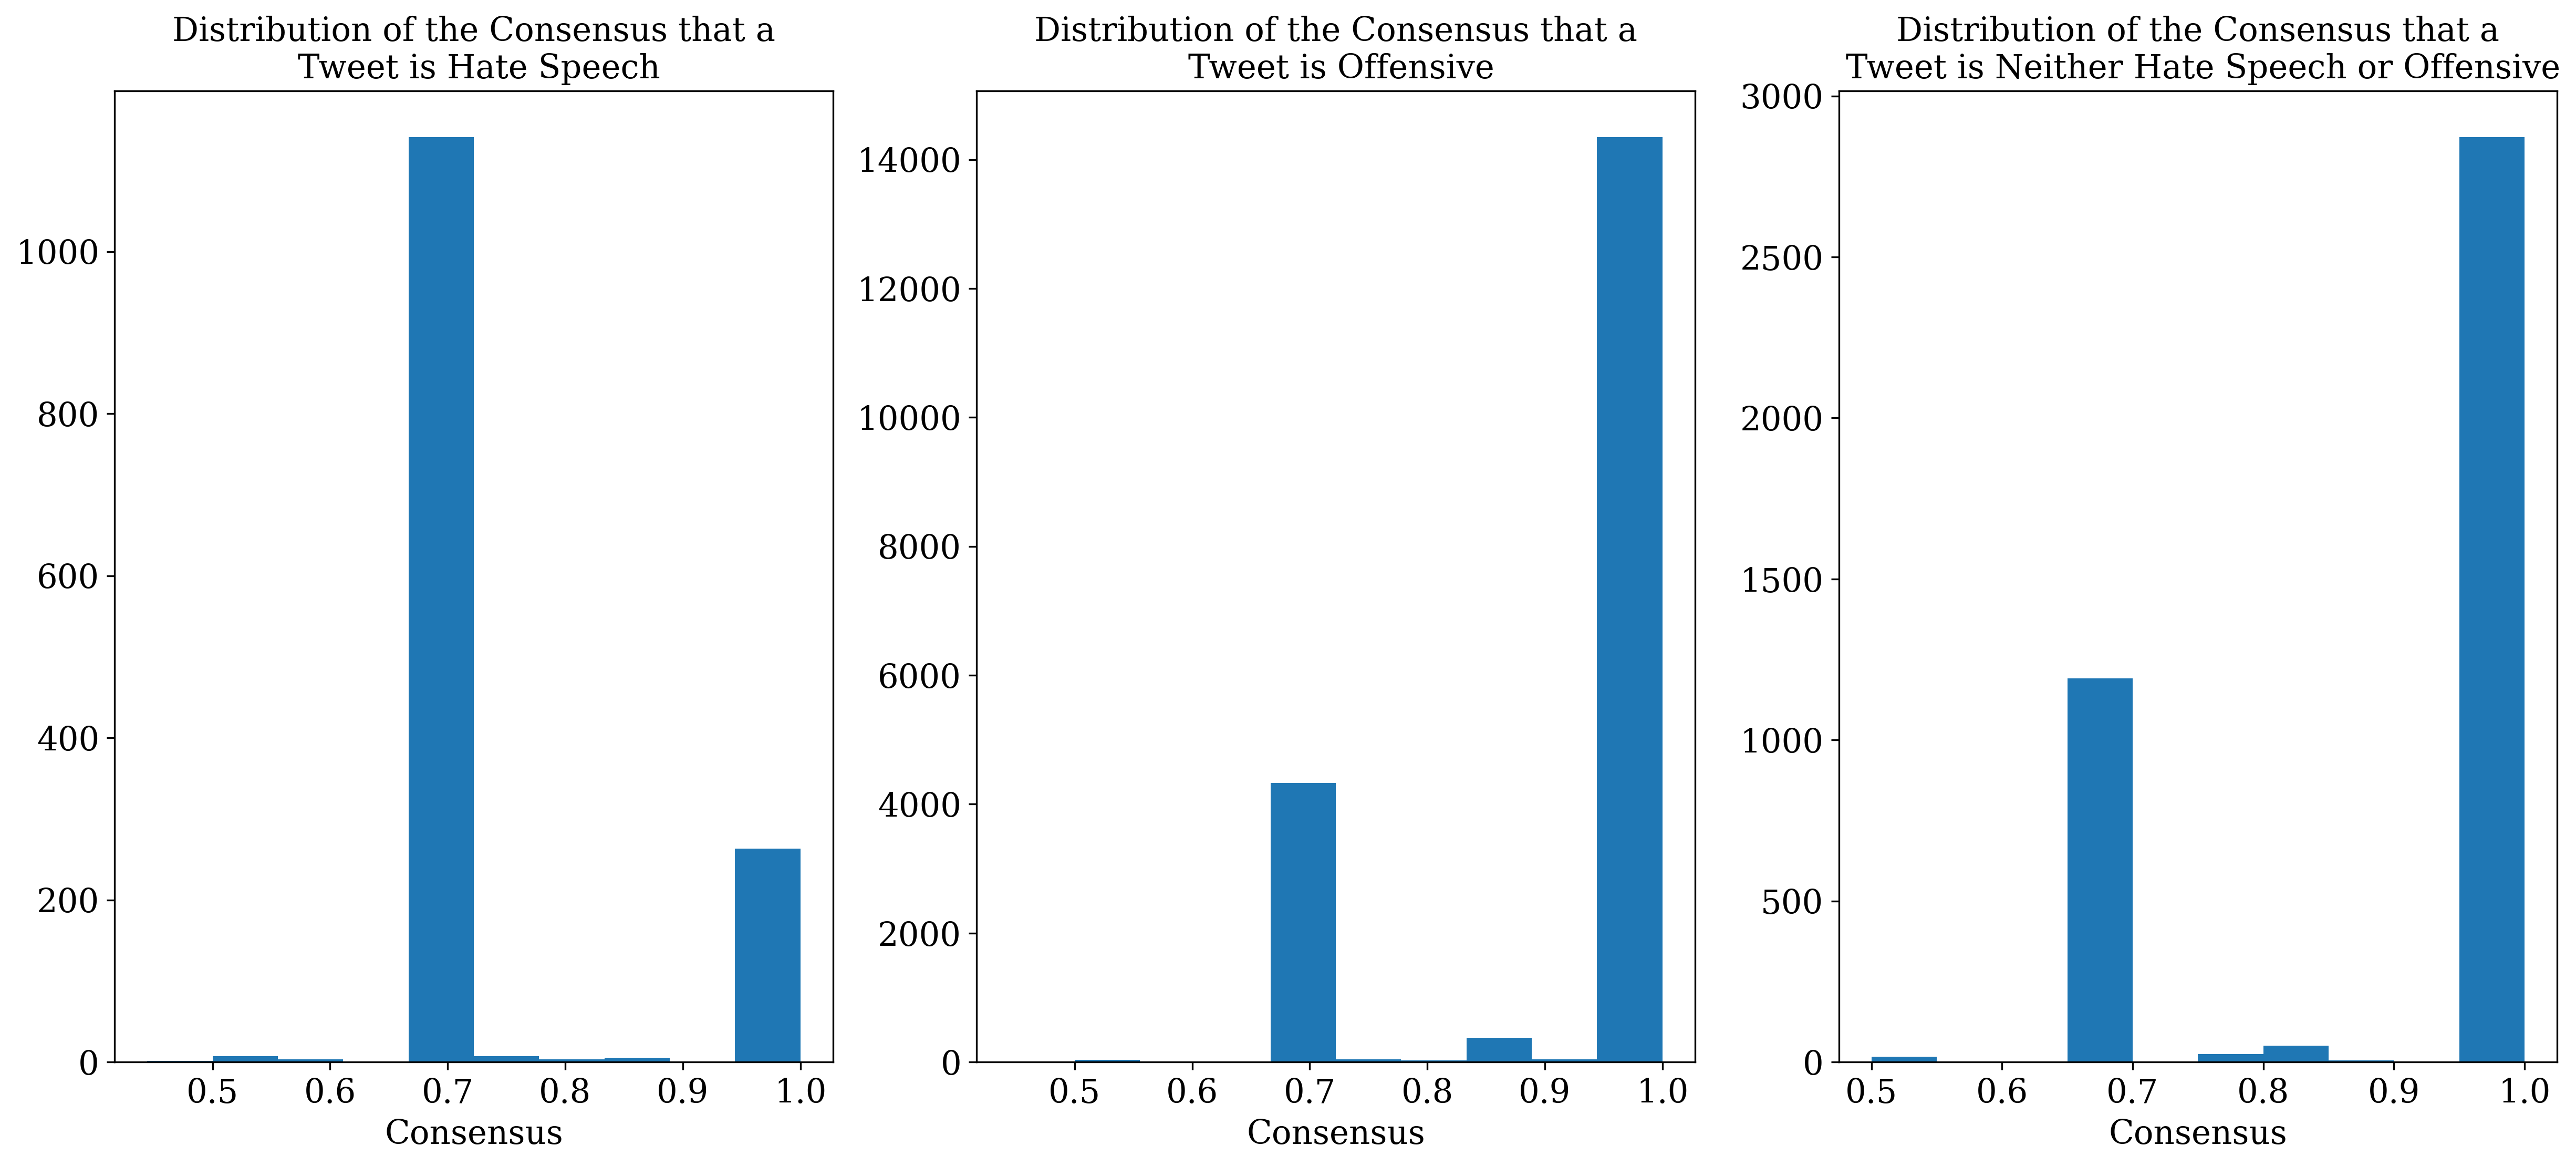

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,8))

axs[0].hist(df_sentiment_0['hate_proportion'])
axs[0].set_title('Distribution of the Consensus that a\n Tweet is Hate Speech')
axs[0].set_xlabel("Consensus")

axs[1].hist(df_sentiment_1['offensive_proportion'])
axs[1].set_title('Distribution of the Consensus that a\n Tweet is Offensive')
axs[1].set_xlabel("Consensus")

axs[2].hist(df_sentiment_2['neither_proportion'])
axs[2].set_title('Distribution of the Consensus that a\n Tweet is Neither Hate Speech or Offensive')
axs[2].set_xlabel("Consensus")

plt.show()

*Is there a lot of overlap in terms of shared words between the groups?*

In [ ]:
# count word frequency of each group
hate_counts = {}
for tokens in df_sentiment_0["tokens"]:
  for word in tokens:
    hate_counts[word] = hate_counts.get(word, 0) + 1
total_hate_words = sum([hate_counts[word] for word in hate_counts])

offensive_counts = {}
for tokens in df_sentiment_1["tokens"]:
  for word in tokens:
    offensive_counts[word] = offensive_counts.get(word, 0) + 1
total_offensive_words = sum([offensive_counts[word] for word in offensive_counts])

neither_counts = {}
for tokens in df_sentiment_2["tokens"]:
  for word in tokens:
    neither_counts[word] = neither_counts.get(word, 0) + 1
total_neither_words = sum([neither_counts[word] for word in neither_counts])

# get top n most frequent words of each group
n = 20
hate_top_words = list(dict(sorted(hate_counts.items(), key=lambda item: item[1], reverse=True)))[:n]
offensive_top_words = list(dict(sorted(offensive_counts.items(), key=lambda item: item[1], reverse=True)))[:n]
neither_top_words = list(dict(sorted(neither_counts.items(), key=lambda item: item[1], reverse=True)))[:n]

# combine all the top words together
all_words = []
for word_pair in hate_top_words:
  if word_pair not in all_words:
    all_words.append(word_pair)

for word_pair in offensive_top_words:
  if word_pair not in all_words:
    all_words.append(word_pair)

for word_pair in neither_top_words:
  if word_pair not in all_words:
    all_words.append(word_pair)

# see how many times the words appear for each group
hate_values = []
offensive_values = []
neither_values = []
for word in all_words:
  # check how many times the word appears in each respective group
  hate_value = 0
  offensive_value = 0
  neither_value = 0

  # normalize by total word count
  if word in hate_counts:
    hate_value = hate_counts[word] / total_hate_words
  if word in offensive_counts:
    offensive_value = offensive_counts[word] / total_offensive_words
  if word in neither_counts:
    neither_value = neither_counts[word] / total_neither_words

  hate_values.append(hate_value)
  offensive_values.append(offensive_value)
  neither_values.append(neither_value)

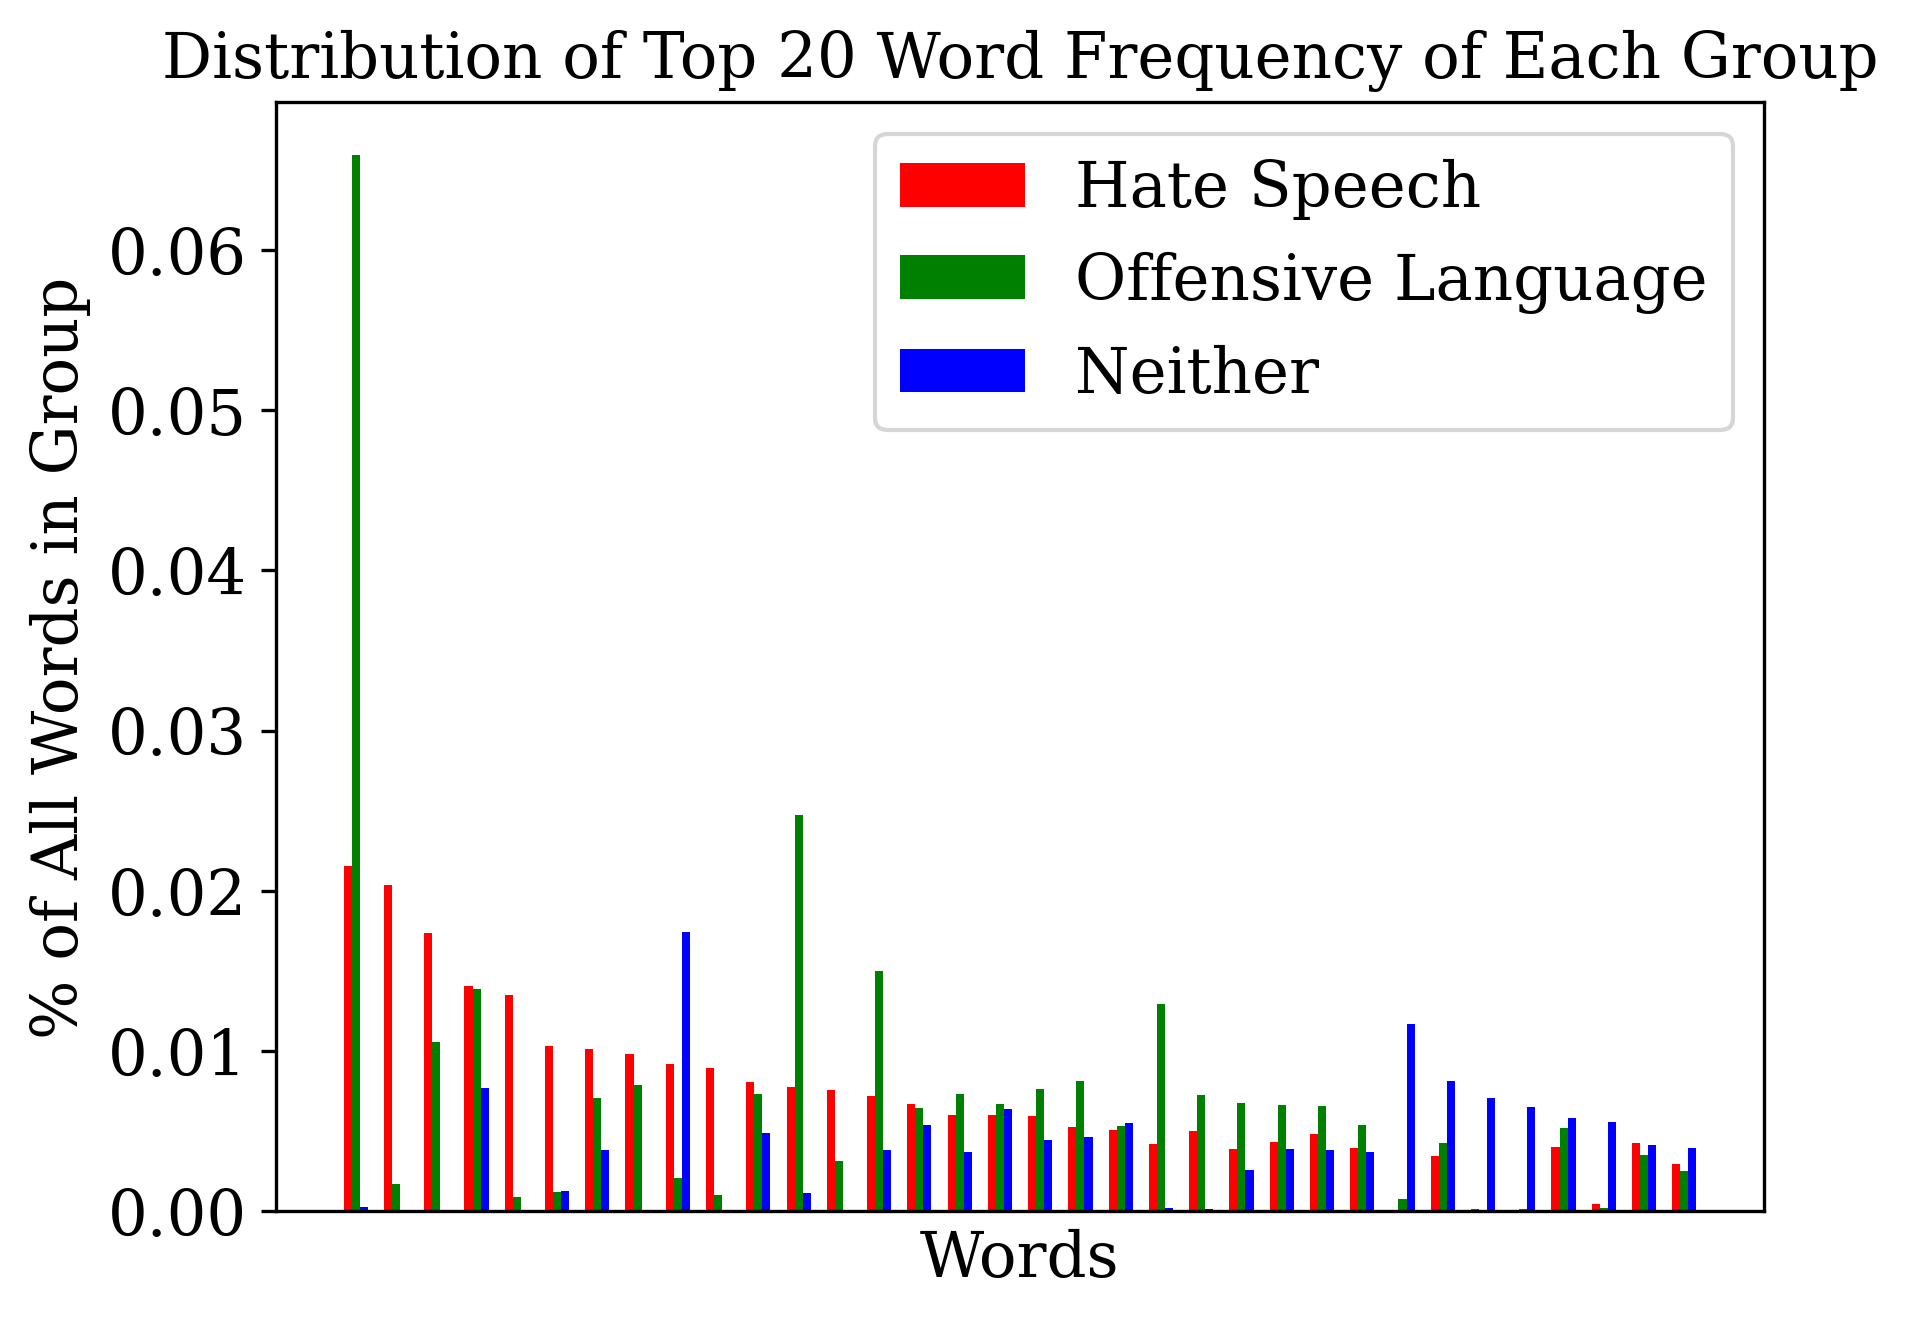

In [ ]:
X_axis = np.arange(len(all_words))

width = 0.2
plt.bar(X_axis, hate_values, width, label = 'Hate Speech', color = 'r')
plt.bar(X_axis + width, offensive_values, width, label = 'Offensive Language', color = 'g')
plt.bar(X_axis + width * 2, neither_values, width, label = 'Neither', color = 'b')

plt.xlabel("Words")
plt.ylabel("% of All Words in Group")
plt.title(f"Distribution of Top {n} Word Frequency of Each Group")
plt.legend()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()


### *Fitting Models*

#### Count-Vectorizing Tweets

In [ ]:
tweets_df['token_string'] = tweets_df['tokens'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer()
tweets_df['token_string'].fillna('', inplace=True)

# Fit the vectorizer
vectorizer.fit(tweets_df['token_string'])
X = vectorizer.transform(tweets_df['token_string'])

# Define features and target
features = X
target = tweets_df.sentiment

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=43)

#### Multinomial Naive Bayes

In [ ]:
model1 = MultinomialNB()

# Fit the model on the training data
model1.fit(X_train, y_train)

# Predict the labels
y_train_pred1 = model1.predict(X_train)
y_test_pred1 = model1.predict(X_test)
y_pred_proba1 = model1.predict_proba(X_test)

# Evaluate the model performance
accuracy_train = accuracy_score(y_train, y_train_pred1)
accuracy_test = accuracy_score(y_test, y_test_pred1)

# Print the results
print("Training Accuracy:", accuracy_train)
print("Testing Accuracy:", accuracy_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred1)

# Calculate macro averaged precision
precision = precision_score(y_test, y_test_pred1, average="macro")

# Calculate macro averaged recall
recall = recall_score(y_test, y_test_pred1, average="macro")

# Calculate macro averaged F1 score
f1 = f1_score(y_test, y_test_pred1, average="macro")



# Print all metrics
print(classification_report(y_test_pred1, y_test))
print("Accuracy:", accuracy)
print("Macro Averaged Precision:", precision)
print("Macro Averaged Recall:", recall)
print("Macro Averaged F1 Score:", f1)


Training Accuracy: 0.9086553011197418
Testing Accuracy: 0.871494855759532
              precision    recall  f1-score   support

           0       0.09      0.34      0.14        77
           1       0.97      0.88      0.93      4213
           2       0.68      0.85      0.76       667

    accuracy                           0.87      4957
   macro avg       0.58      0.69      0.61      4957
weighted avg       0.92      0.87      0.89      4957

Accuracy: 0.871494855759532
Macro Averaged Precision: 0.6916346174001942
Macro Averaged Recall: 0.580576780370744
Macro Averaged F1 Score: 0.6084409313443845


[[  26  231   29]
 [  39 3725   69]
 [  12  257  569]]


Text(0.5, 1.0, 'Multinomial Naive Bayes')

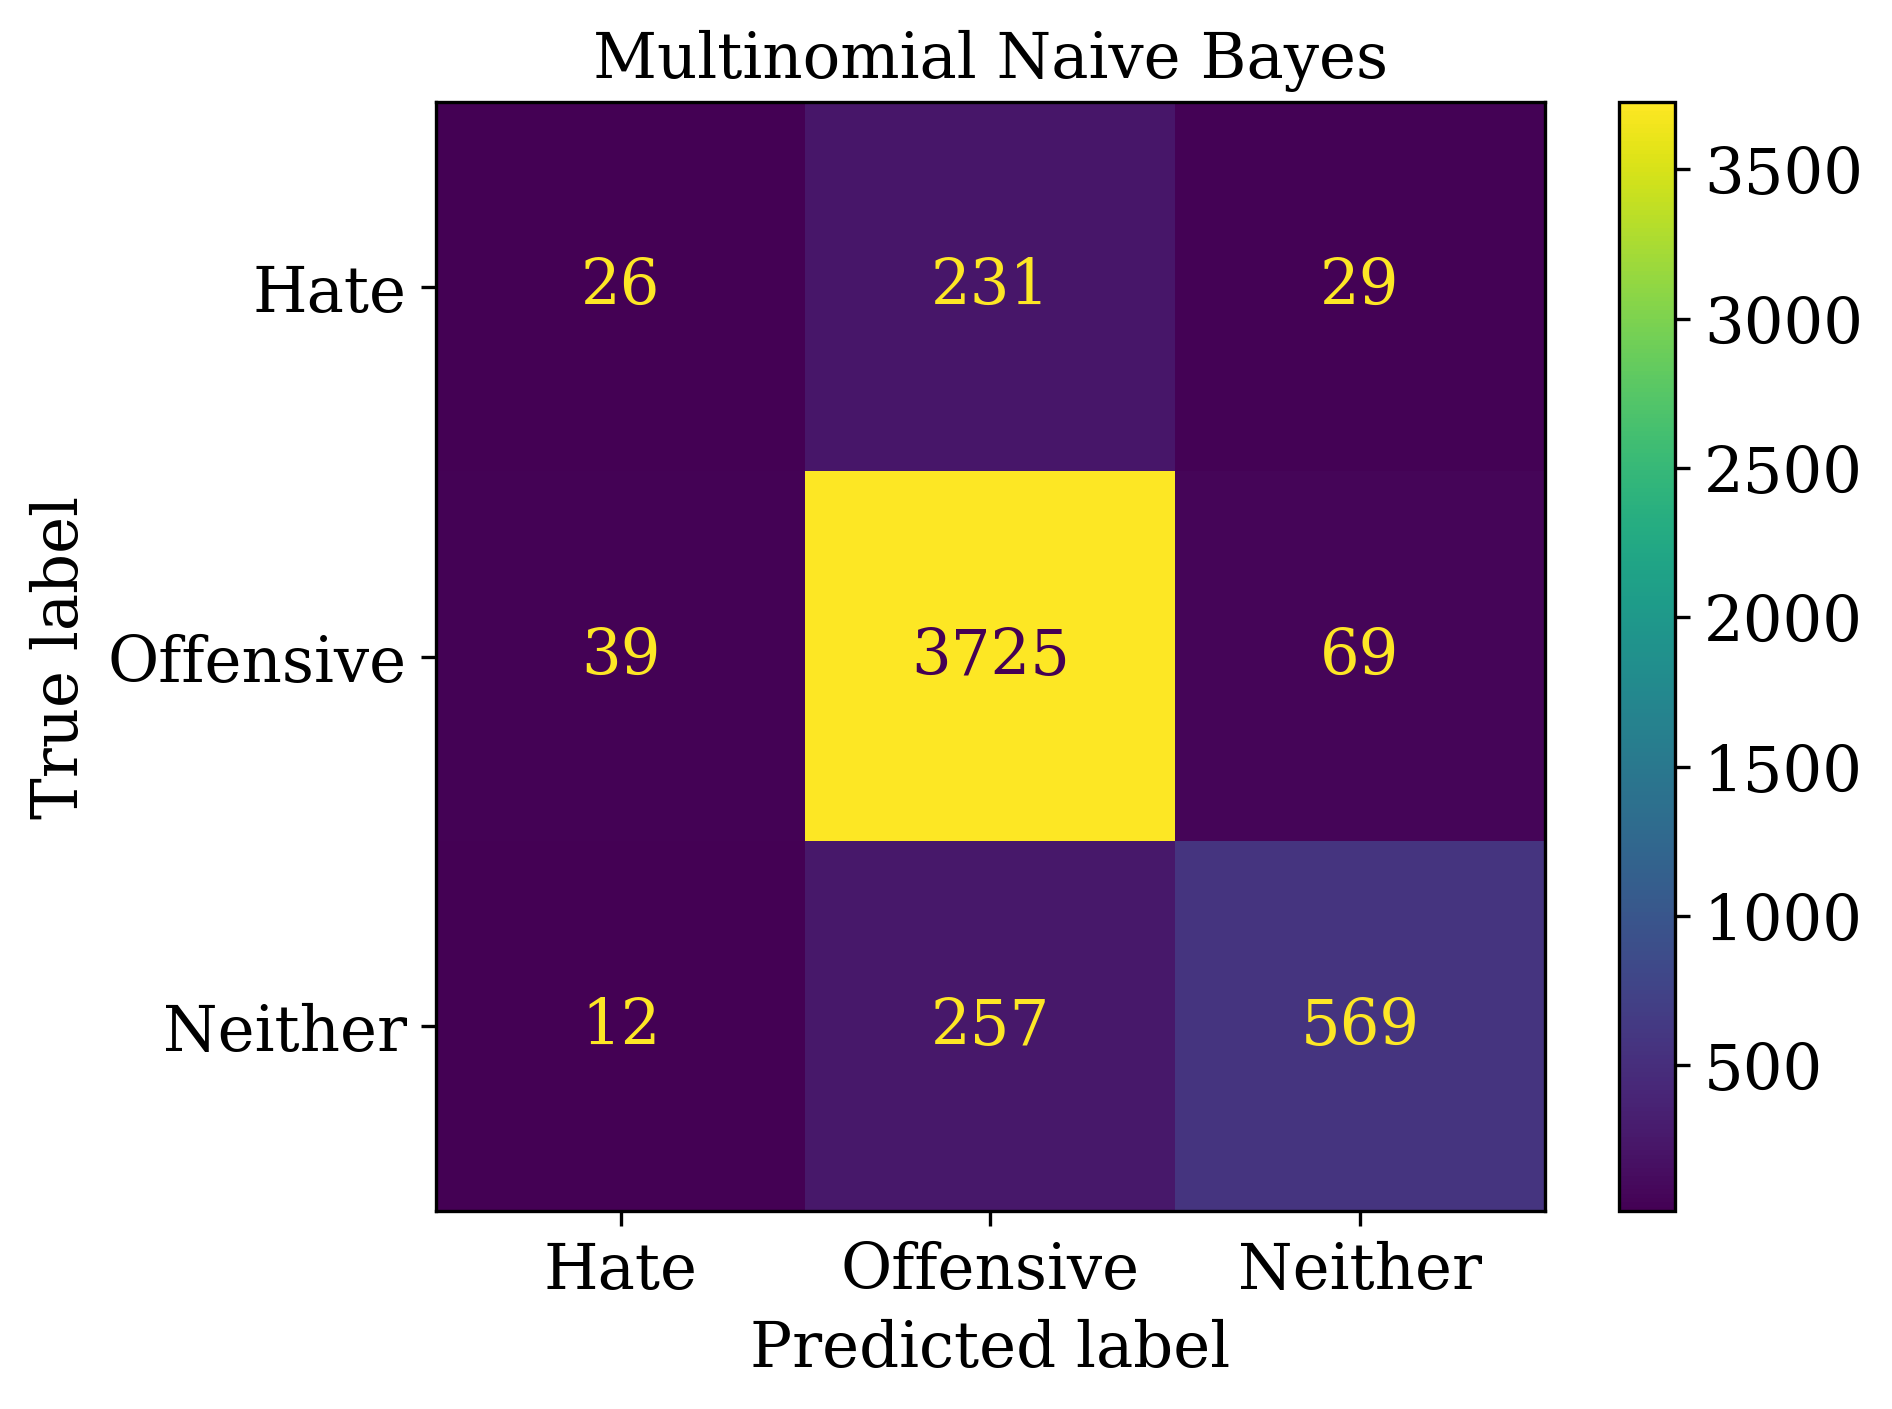

In [ ]:
labels = ['Hate', 'Offensive', 'Neither']

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred1)
print(confusion_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot()
disp.ax_.set_title("Multinomial Naive Bayes")

#### Logistic Regression

In [ ]:
# Instantiate the model
model2 = LogisticRegression()

# Fit the model to the training data
model2.fit(X_train, y_train)

# Predict the labels for the test data
y_pred2 = model2.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)
print(classification_report(y_pred2, y_test))

Accuracy: 0.9039741779301997
              precision    recall  f1-score   support

           0       0.24      0.45      0.31       154
           1       0.95      0.93      0.94      3917
           2       0.90      0.85      0.88       886

    accuracy                           0.90      4957
   macro avg       0.70      0.74      0.71      4957
weighted avg       0.92      0.90      0.91      4957



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[  69  184   33]
 [  78 3657   98]
 [   7   76  755]]


Text(0.5, 1.0, 'Logistic Regression')

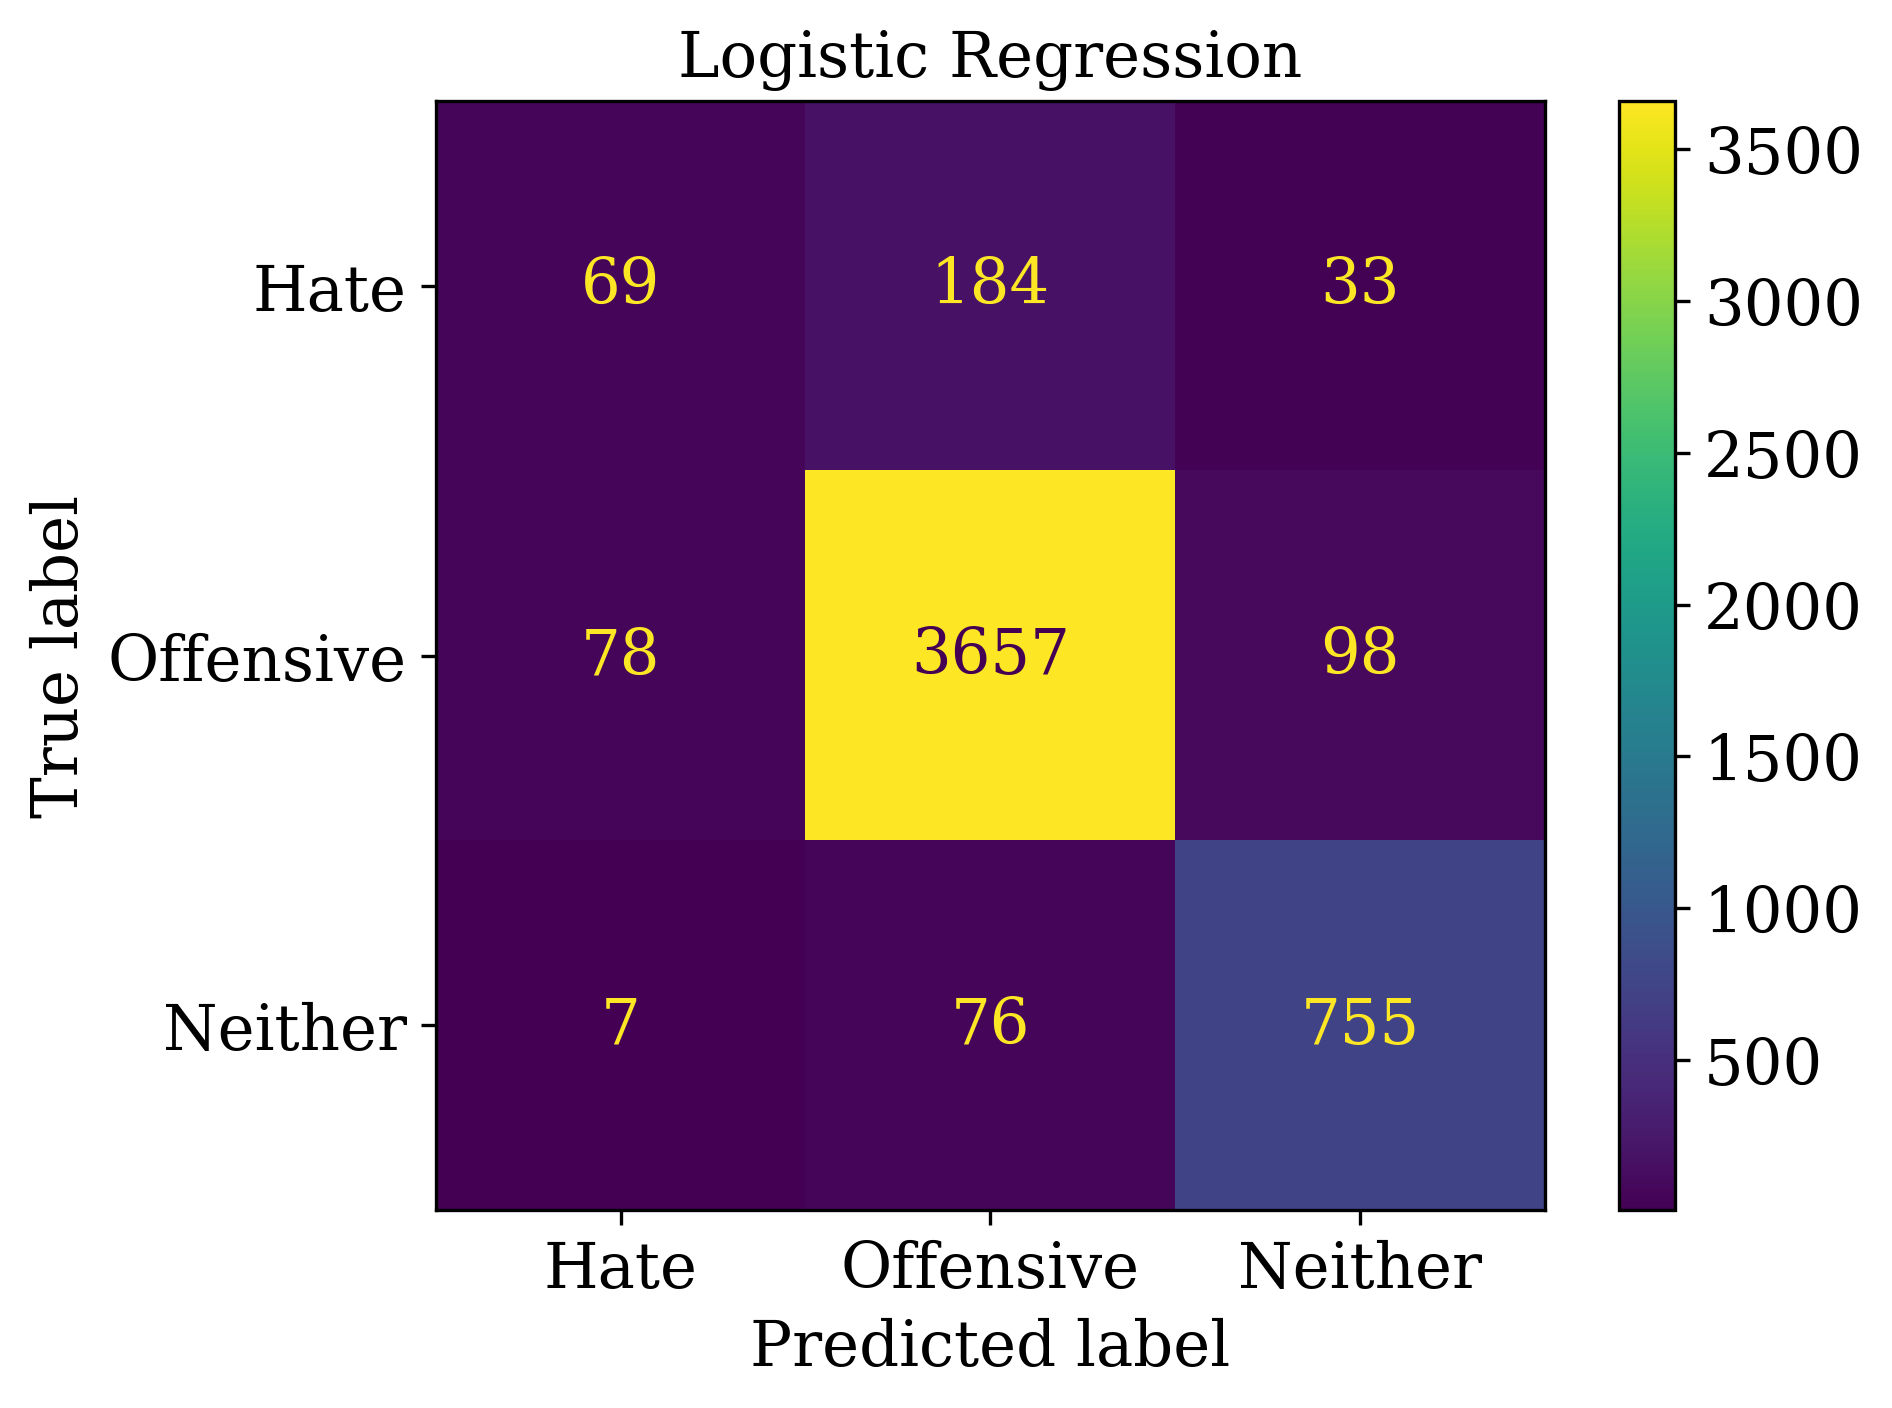

In [ ]:
# plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred2)
print(confusion_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot()
disp.ax_.set_title("Logistic Regression")

#### Decision Tree

In [ ]:
# Instantiate the model
model3 = DecisionTreeClassifier()

# Fit the model to the training data
model3.fit(X_train, y_train)

# Predict the labels for the test data
y_pred3 = model3.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred3)
print("Accuracy:", accuracy)
print(classification_report(y_pred3, y_test))


Accuracy: 0.8763364938470849
              precision    recall  f1-score   support

           0       0.33      0.31      0.32       303
           1       0.93      0.92      0.93      3849
           2       0.82      0.86      0.84       805

    accuracy                           0.88      4957
   macro avg       0.69      0.70      0.70      4957
weighted avg       0.87      0.88      0.88      4957



[[  95  168   23]
 [ 182 3559   92]
 [  26  122  690]]


Text(0.5, 1.0, 'Decision Tree')

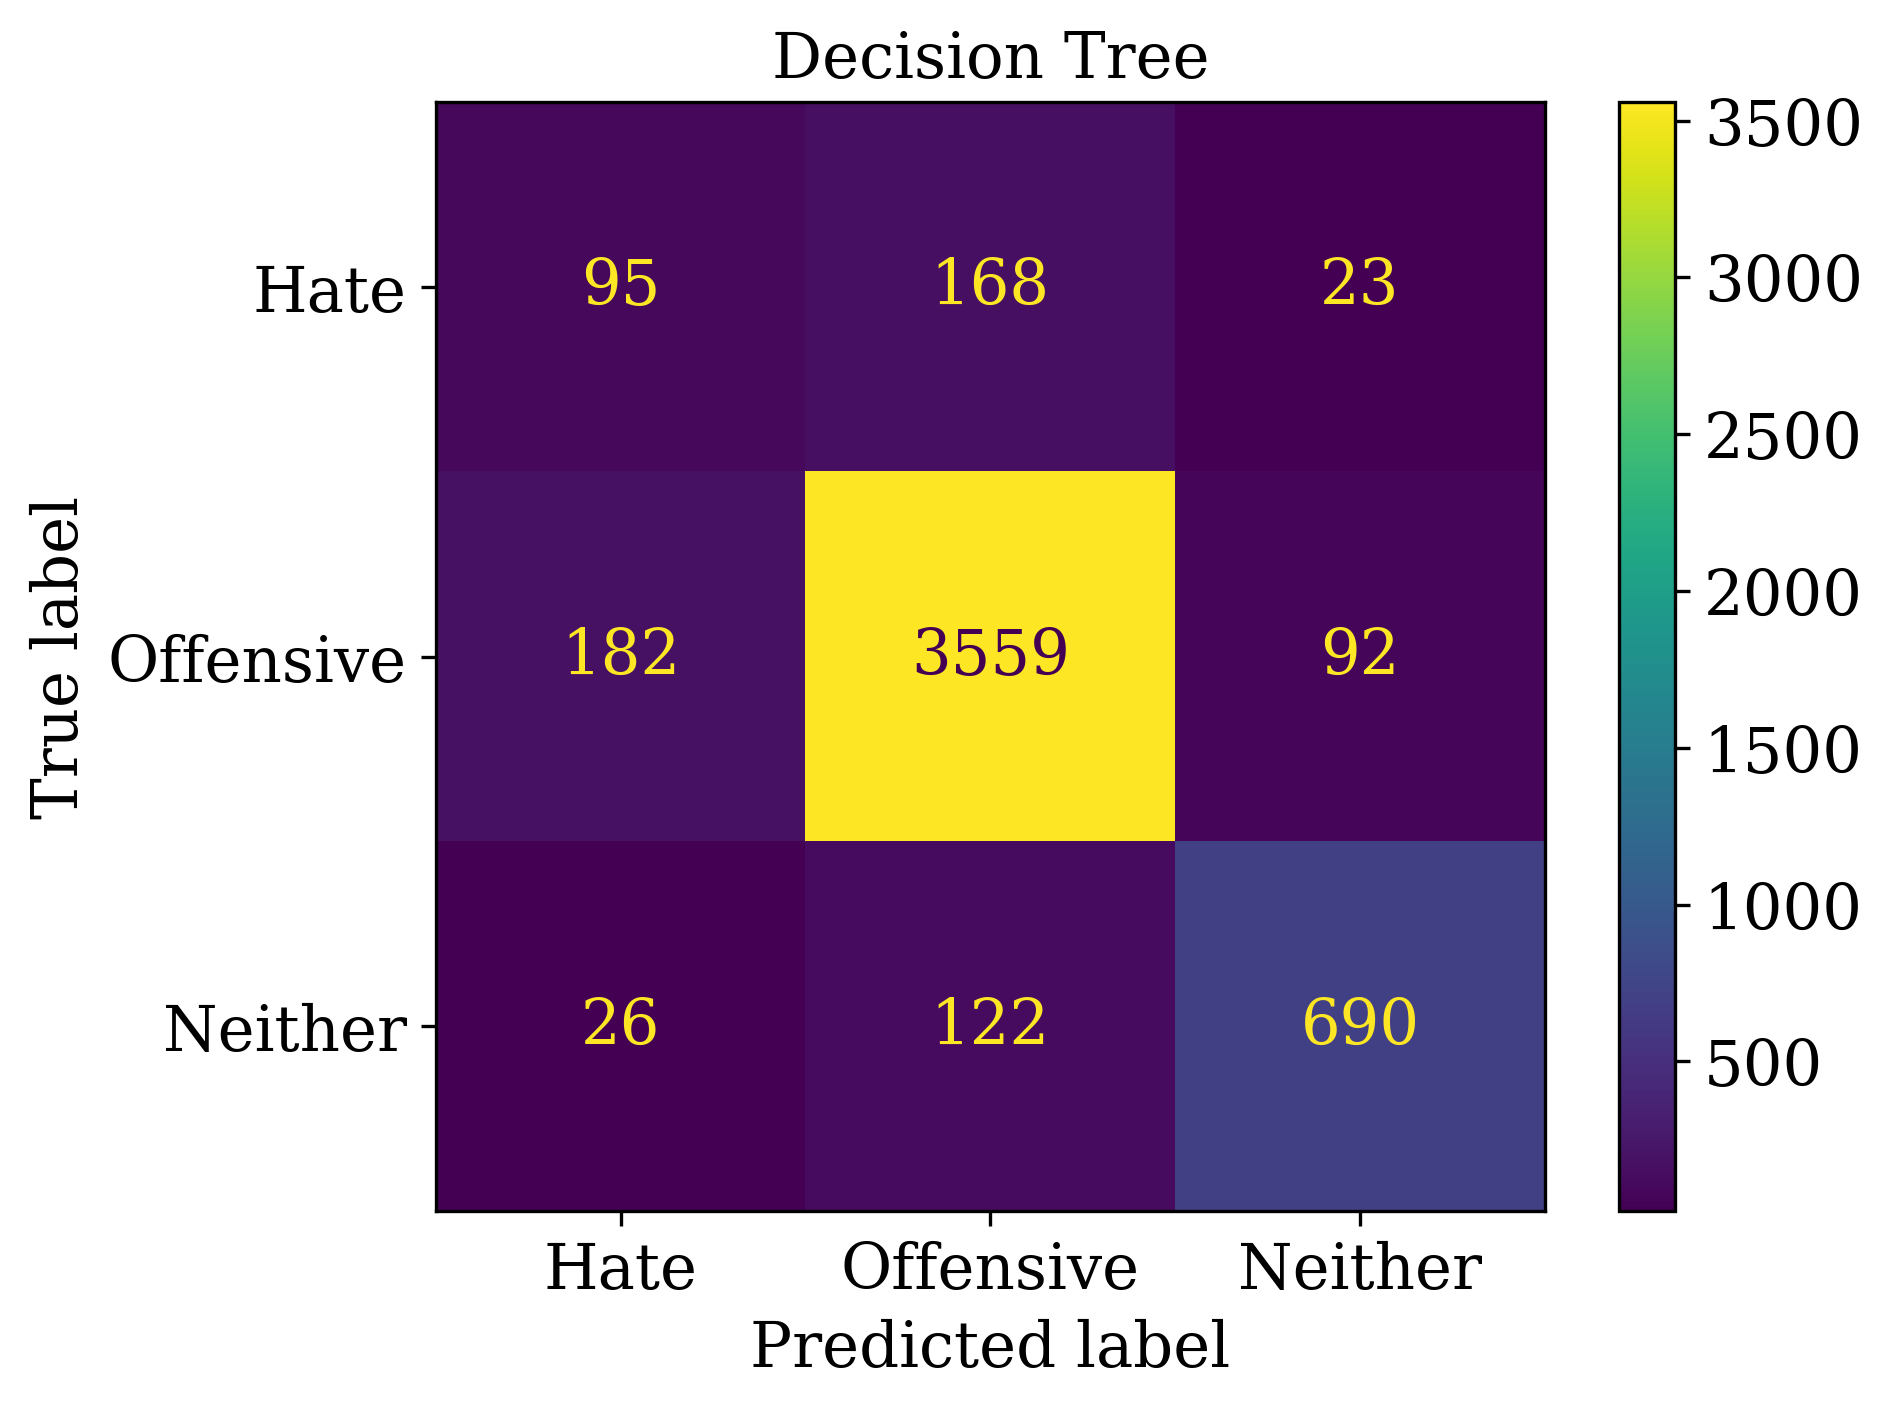

In [ ]:
# plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred3)
print(confusion_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot()
disp.ax_.set_title("Decision Tree")

#### Random Forest

In [ ]:
# Instantiate the model
model4 = RandomForestClassifier()

# Fit the model to the training data
model4.fit(X_train, y_train)

# Predict the labels for the test data
y_pred4 = model4.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred4)
print("Accuracy:", accuracy)
print(classification_report(y_pred4, y_test))


Accuracy: 0.8938874319144644
              precision    recall  f1-score   support

           0       0.25      0.45      0.32       158
           1       0.95      0.92      0.94      3965
           2       0.85      0.85      0.85       834

    accuracy                           0.89      4957
   macro avg       0.68      0.74      0.70      4957
weighted avg       0.91      0.89      0.90      4957



[[  71  191   24]
 [  83 3650  100]
 [   4  124  710]]


Text(0.5, 1.0, 'Random Forest')

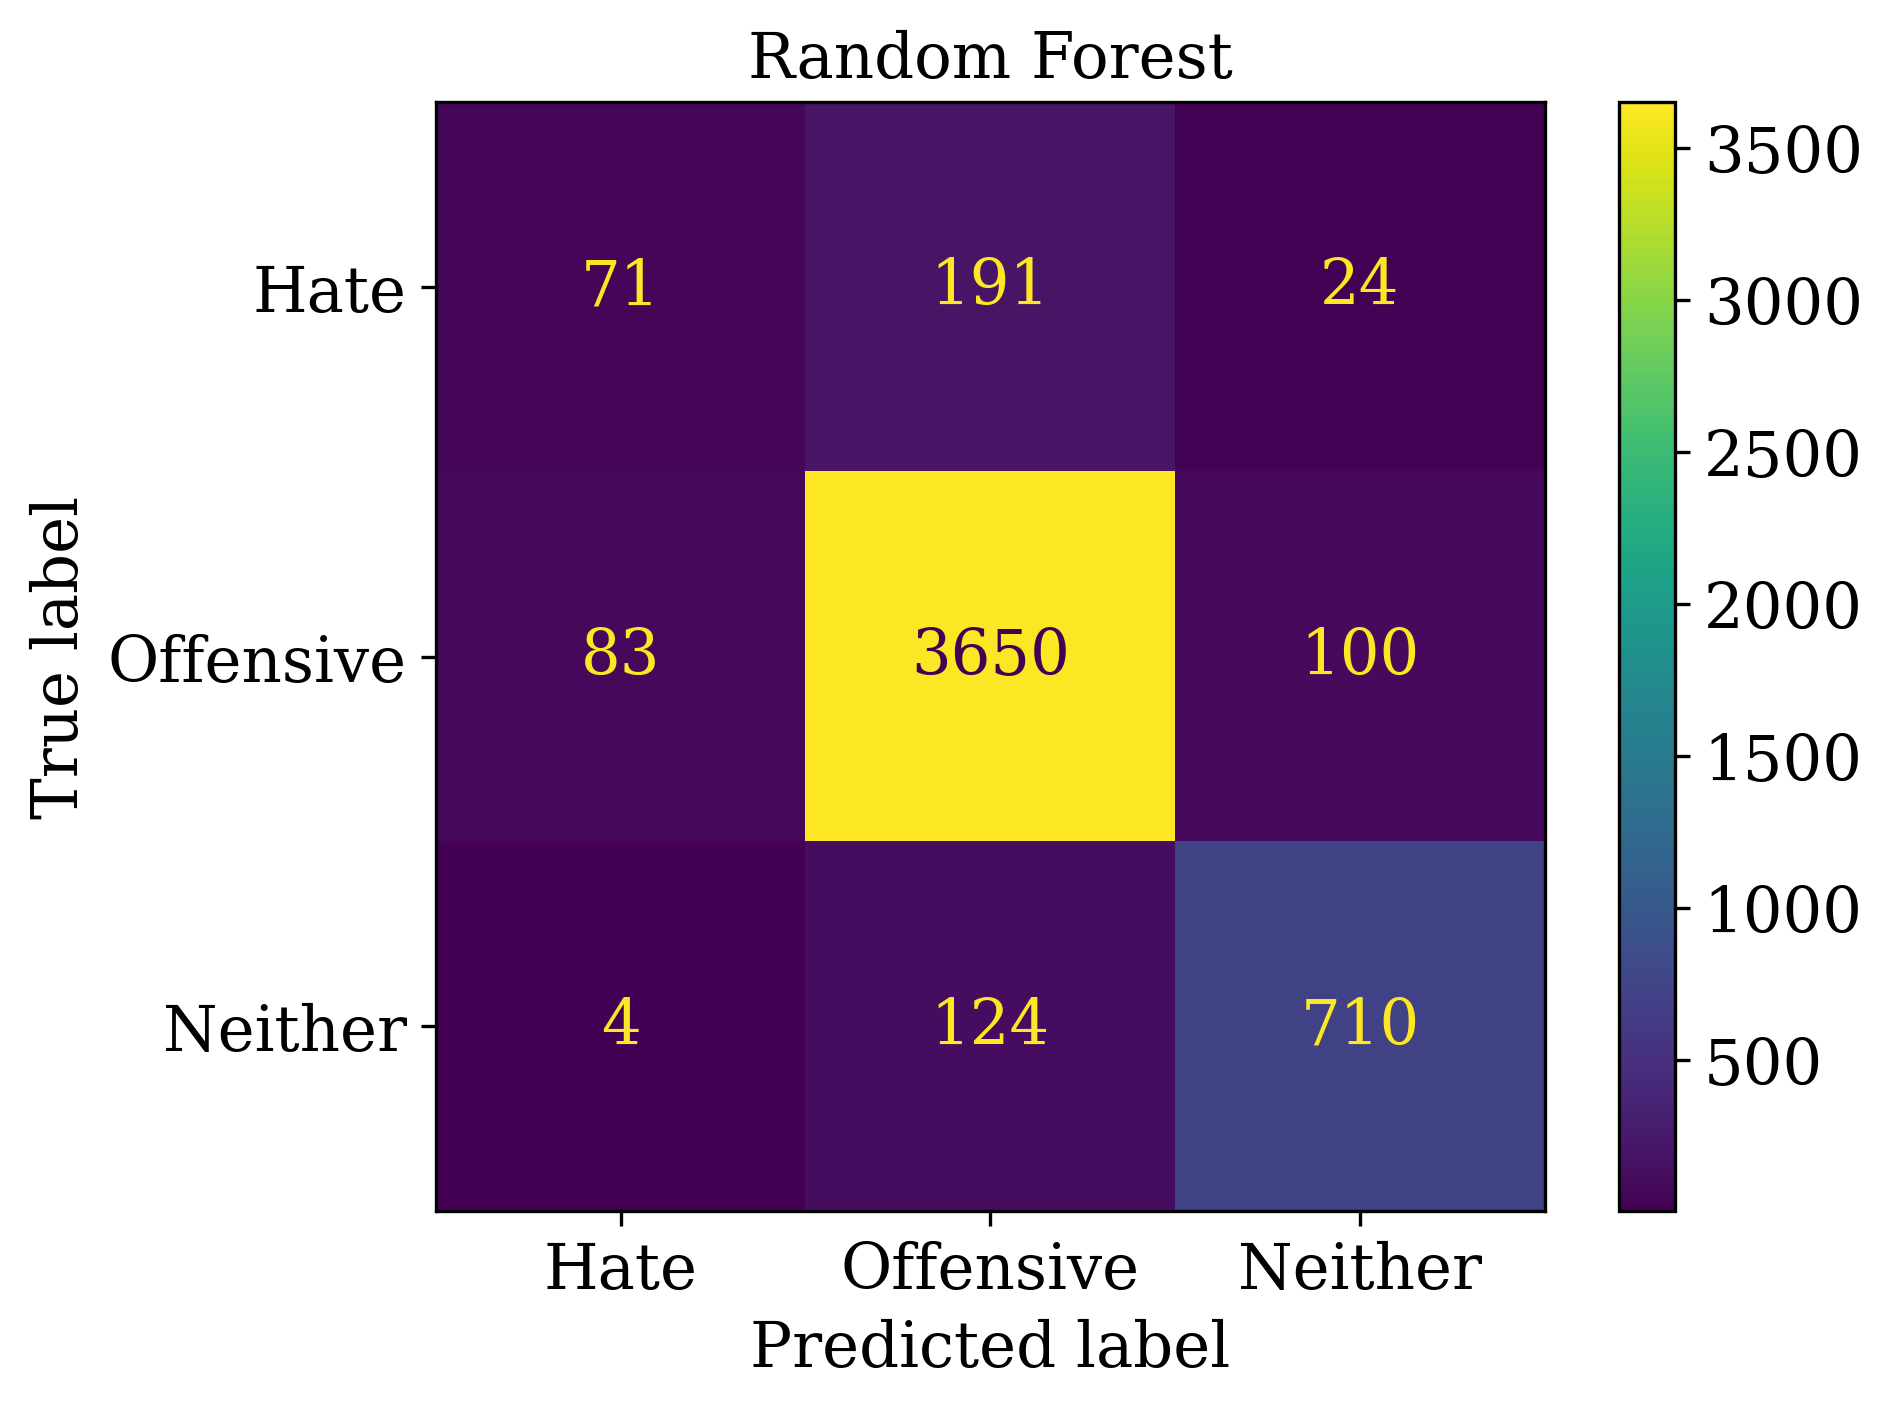

In [ ]:
# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred4)
print(confusion_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot()
disp.ax_.set_title("Random Forest")